# Gaussian decomposition

The following is an implementation of GaussPy gaussian decomposition using experimental data from ENPH 453 lab on photoluminescence. The tutorial here was used as a starting point: https://gausspy.readthedocs.io/en/latest/tutorial.html#multiple-gaussians-tutorial

## Data preparation

In [50]:
# Import experimental data and store in .pkl format,
# required for GaussPy. This serializes the data for 
# efficient saving/loading

import numpy as np
import pickle 
import pandas as pd


# Specify filename of output data
OUTPUT_FILENAME = 'filter03_temp90.pkl'
INPUT_FILENAME = 'Group25_Jan31_00_filter03_int005_temp90.csv'

# Read and trim csv data
input_csv = open(INPUT_FILENAME)
data_all = np.loadtxt(input_csv,delimiter=",")
data_list_raw = data_all[20:,1]
x_val_raw = data_all[20:,0]
data_list_raw = np.subtract(data_list_raw,np.average(data_list_raw[0:50])) # centre at y=0
input_csv.close()
error = np.ones(len(x_val_raw))*5 # error estimate

# Store in list
data = {}
data['data_list'] = [data_list_raw]
data['x_values'] = [x_val_raw]
data['errors'] = [error]

# Dump data to output file
pickle.dump(data, open(OUTPUT_FILENAME, 'wb'))

## Decompose data

In [51]:
# Decompose multiple Gaussian dataset using AGD
import gausspy.gp as gp

# Specify necessary parameters
alpha1 = 0.06 
snr_thresh = 3
FILENAME_DATA = OUTPUT_FILENAME
FILENAME_DATA_DECOMP = 'filter03_temp90_decomp.pkl'

# Load GaussPy
g = gp.GaussianDecomposer()

# Set AGD parameters
g.set('phase', 'one')
g.set('SNR_thresh', [snr_thresh, snr_thresh])
g.set('alpha1', alpha1)

# Run GaussPy
data_decomp = g.batch_decomposition(FILENAME_DATA)

# Save decomposition information
pickle.dump(data_decomp, open(FILENAME_DATA_DECOMP, 'wb'))

using 6 out of 8 cpus
   ---->   0


0.00it [00:00, ?it/s]
0it [00:00, ?it/s]

SUCCESS
100 finished.%


## Plot results

{'index_fit': [[0, 0]], 'amplitudes_fit': [[22708.324773890912, 9877.79581134566]], 'fwhms_fit': [[5.23607588797319, 21.862957617829085]], 'means_fit': [[533.4267545136868, 541.4393595912627]], 'index_initial': [[0, 0]], 'amplitudes_initial': [array([26706.22613579, 11045.41863655])], 'fwhms_initial': [array([ 6.58410975, 12.23035144])], 'means_initial': [array([533.4425, 541.6315])], 'amplitudes_fit_err': [[118.12177769378603, 60.598173129972054]], 'fwhms_fit_err': [[0.03409083343331455, 0.134122368460276]], 'means_fit_err': [[0.011747492594574761, 0.08107356265011699]], 'best_fit_rchi2': [[2800.0949976215056]], 'amplitudes_fit_em': [], 'fwhms_fit_em': [], 'means_fit_em': [], 'means_fit_err_em': [], 'amplitudes_fit_err_em': [], 'fwhms_fit_err_em': [], 'fit_labels': []}


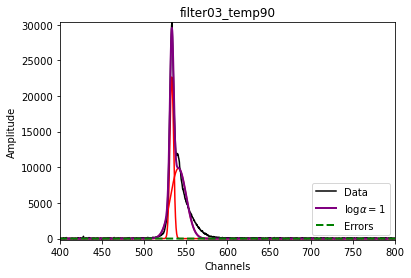

In [56]:
# Plot GaussPy results
import matplotlib.pyplot as plt

def gaussian(amp, fwhm, mean):
    return lambda x: amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)

def unravel(list):
    return np.array([i for array in list for i in array])

data = pickle.load(open(FILENAME_DATA, 'rb'))
spectrum = unravel(data['data_list'])
chan = unravel(data['x_values'])
errors = unravel(data['errors'])

data_decomp = pickle.load(open(FILENAME_DATA_DECOMP, 'rb'))
means_fit = unravel(data_decomp['means_fit'])
amps_fit = unravel(data_decomp['amplitudes_fit'])
fwhms_fit = unravel(data_decomp['fwhms_fit'])

print(data_decomp)

fig = plt.figure()
ax = fig.add_subplot(111)

model = np.zeros(len(chan))

for j in range(len(means_fit)):
    component = gaussian(amps_fit[j], fwhms_fit[j], means_fit[j])(chan)
    model += component
    ax.plot(chan, component, color='red', lw=1.5) # Individual gaussians

ax.plot(chan, spectrum, label='Data', color='black', linewidth=1.5) # Original Data
ax.plot(chan, model, label = r'$\log\alpha=1.$', color='purple', linewidth=2.) # Net gaussian
ax.plot(chan, errors, label = 'Errors', color='green', linestyle='dashed', linewidth=2.) # err

ax.set_xlabel('Channels')
ax.set_ylabel('Amplitude')
ax.set_title(FILENAME_DATA.rstrip(".pkl"))


ax.set_xlim(400,800)
ax.set_ylim(np.min(spectrum),np.max(spectrum))
ax.legend(loc=4)

plt.show()